In [219]:
# initializing

import pandas as pd
import pandas_gbq as pgbq
from multiprocessing import Pool
from scipy import stats
import os
import time
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('MacOSX') 

google_project_id = 'solid-ridge-104914'
dataset = 'community_networks'

In [95]:
def build_table(module_type):
    print(module_type)
    if __name__ == '__main__':
        with Pool(processes=len(sql_modules)) as pool:
            result = pool.map(bigquery_worker, (range(len(sql_modules),)))
            pool.close()
            pool.join()
    joined = result[0].set_index('cid', drop=True)
    print('Joining ',module_type,' modules', sep='')
    for i in range(len(result)-1):
        joined = joined.join(result[i+1].set_index('cid'), how='left', lsuffix='_left')
    table = joined.replace([np.inf,-np.inf], np.nan)
    table.fillna(0, inplace=True)
    table.sort_index(inplace=True)
    if re.match('community_facts', module_type) is None:
        table = add_network_stats(table, module_type)
    #pgbq.to_gbq(network_stats, dataset+'.'+sql_module_type+'_stats', google_project_id, if_exists='replace', verbose=False)
    print('Done', sep='')
    return(table)

def open_active_modules(module_type):
    sql_files = list(map(lambda x: os.path.splitext(x), os.listdir(directory)))
    sql_modules = list()
    for i in range(len(sql_files)):
        if sql_files[i][1] == '.on':
            sql_modules.append(sql_files[i][0])
    return(sql_modules)

def bigquery_worker(i):
    sql_module = sql_modules[i]
    print('Starting module ',i,': ',sql_modules[i], sep='')
    try:
        result = pgbq.read_gbq('select * from community_networks.'+module_type+'_'+sql_module, google_project_id, dialect='standard', verbose=False)
        print(module_type,'_',sql_module,' table found.', sep='')
    except:
        print(module_type,'_',sql_module,' table does not exist, generating now', sep='')
        with open(directory+'/'+sql_module+'.on') as query_file:
            query = query_file.read()
        result = pgbq.read_gbq(query, google_project_id, dialect='standard', verbose=False)
        print('Creating new ',module_type,'_',sql_module,' table', sep='')
        pgbq.to_gbq(result, dataset+'.'+module_type+'_'+sql_module, google_project_id, if_exists='replace', verbose=False)
        print('Module ',i,': ',sql_module,'query complete', sep='')
    return (result)

def add_network_stats(df, sql_module_type):
    edges = df[sql_module_type+'_edges']
    nodes = df[sql_module_type+'_nodes']
    avg_indegree = df[sql_module_type+'_avg_indegree']
    avg_outdegree = df[sql_module_type+'_avg_outdegree']
    #df[sql_module_type+'_network_density_X_100'] = (edges/(nodes*(nodes-1)/2))*100
    df[sql_module_type+'_indegree_skew'] = (avg_indegree-avg_outdegree)/avg_outdegree
    df.drop([sql_module_type+'_edges',sql_module_type+'_nodes'], axis=1, inplace=True)
    return(df)

In [249]:
sql_module_types = ['community_facts','transaction','follow']

data = pgbq.read_gbq('select id cid from vs_reporting.communities', google_project_id, dialect='standard', verbose=False).set_index('cid', drop=False)

for module_type in sql_module_types:
    directory = '/Users/joshharris/community_health/sql/module_types/'+module_type
    sql_modules = open_active_modules(module_type)
    module_table = build_table(module_type)
    data = data.join(module_table, how='left', lsuffix='_left')

labeled_features = data.replace([np.inf,-np.inf], np.nan)
labeled_features.fillna(0, inplace=True)
labeled_features.drop(labeled_features[labeled_features.avg_communities_per_user == 0].index, inplace=True)
labeled_features.drop(labeled_features[labeled_features.items_posted_last_month < 100].index, inplace=True)
#labeled_features.drop(labeled_features[labeled_features.items_posted_last_month > 100000].index, inplace=True)


community_facts
Starting module 3: items_posted
Starting module 1: communities_per_user
Starting module 5: pct_female_mau
Starting module 2: distance_from_center
Starting module 0: _community_age
Starting module 4: m3_total_retention
Starting module 6: pct_with_about_me
community_facts_pct_with_about_me table found.
community_facts_pct_female_mau table found.
community_facts__community_age table found.
community_facts_communities_per_user table found.
community_facts_items_posted table found.
community_facts_distance_from_center table found.
community_facts_m3_total_retention table found.
Joining community_facts modules
Done
transaction
Starting module 0: edge_weight
Starting module 1: edges
Starting module 2: indegree
Starting module 3: nodes
Starting module 4: outdegree
transaction_edges table found.
transaction_nodes table found.
transaction_outdegree table found.
transaction_edge_weight table found.
transaction_indegree table found.
Joining transaction modules
Done
follow
Starting 

In [250]:
# Cross correlate community facts and output key correlations

variables = list(labeled_features)[2:len(labeled_features)] #this is not a good way to create the list of variables.. why not
print(variables)
corr_matrix = pd.DataFrame(index=variables, columns=variables)
key_correlations = pd.DataFrame(columns=['pair','coefficient'])
corr_checked = list()

i = 0
j = 0

for i in range(len(variables)):
    for j in range(len(variables)):
        pair = variables[i]+','+variables[j]
        rho, pval = stats.spearmanr(labeled_features[[variables[i],variables[j]]])
        corr_matrix.set_value(variables[i], variables[j], rho)
        if pair not in corr_checked and rho < 0.99 and (rho > 0.4 or rho < -0.4):
            key_correlations.loc[len(key_correlations)] = [pair, rho]
            corr_checked.append(variables[j]+','+variables[i]) 
            

corr_matrix.reset_index(inplace=True)
key_correlations.sort_values(by='coefficient', ascending=False, inplace=True)
key_correlations.reset_index(drop=True, inplace=True)

#Save to BigQuery
#pgbq.to_gbq(transaction_corr_matrix, 'community_networks.transaction_corr_matrix_over_1000', google_project_id, if_exists='replace')
#pgbq.to_gbq(transaction_key_correlations, 'community_networks.transaction_key_correlations_over_1000', google_project_id, if_exists='replace')


['age', 'avg_communities_per_user', 'avg_distance_from_center', 'items_posted_last_month', 'm3_total_retention', 'pct_female_mau', 'pct_with_about_me', 'transaction_avg_weight', 'transaction_avg_indegree', 'transaction_avg_outdegree', 'transaction_indegree_skew', 'follow_avg_indegree', 'follow_avg_outdegree', 'follow_indegree_skew']


In [251]:
key_correlations

,pair,coefficient
0,"transaction_avg_outdegree,follow_avg_outdegree",0.940031
1,"items_posted_last_month,follow_avg_outdegree",0.730256
2,"items_posted_last_month,transaction_avg_outdegree",0.699023
3,"transaction_indegree_skew,follow_indegree_skew",0.692379
4,"avg_communities_per_user,transaction_indegree_...",0.667225
5,"follow_avg_indegree,follow_indegree_skew",0.643911
6,"items_posted_last_month,m3_total_retention",0.602079
7,"m3_total_retention,follow_avg_outdegree",0.551984
8,"pct_with_about_me,transaction_avg_outdegree",0.512345
9,"m3_total_retention,transaction_avg_outdegree",0.511852


In [252]:
corr_matrix

,index,age,avg_communities_per_user,avg_distance_from_center,items_posted_last_month,m3_total_retention,pct_female_mau,pct_with_about_me,transaction_avg_weight,transaction_avg_indegree,transaction_avg_outdegree,transaction_indegree_skew,follow_avg_indegree,follow_avg_outdegree,follow_indegree_skew
0,age,1,-0.595342,0.233421,0.449728,0.140649,0.38243,0.356774,0.103052,0.0373006,0.377555,-0.389745,0.207349,0.339352,-0.0816445
1,avg_communities_per_user,-0.595342,1,-0.0325929,-0.691052,-0.410375,-0.307842,-0.259875,0.0773403,-0.0542556,-0.64109,0.667225,0.0442324,-0.647879,0.479621
2,avg_distance_from_center,0.233421,-0.0325929,1,-0.177862,-0.0997348,0.0480203,0.0573853,0.188126,0.154904,0.0531774,0.0709907,0.279248,0.0446637,0.215971
3,items_posted_last_month,0.449728,-0.691052,-0.177862,1,0.602079,0.307588,0.286741,-0.173203,0.0608127,0.699023,-0.722785,-0.11772,0.730256,-0.599795
4,m3_total_retention,0.140649,-0.410375,-0.0997348,0.602079,1,0.188613,0.0832816,-0.350402,0.113914,0.511852,-0.477964,-0.123587,0.551984,-0.462545
5,pct_female_mau,0.38243,-0.307842,0.0480203,0.307588,0.188613,1,0.274198,0.0883482,0.168367,0.32723,-0.249887,0.166527,0.298949,-0.0476554
6,pct_with_about_me,0.356774,-0.259875,0.0573853,0.286741,0.0832816,0.274198,1,0.324321,0.300635,0.512345,-0.383229,0.20562,0.464297,-0.217044
7,transaction_avg_weight,0.103052,0.0773403,0.188126,-0.173203,-0.350402,0.0883482,0.324321,1,0.31681,0.185237,0.0243461,0.278175,0.0229939,0.20343
8,transaction_avg_indegree,0.0373006,-0.0542556,0.154904,0.0608127,0.113914,0.168367,0.300635,0.31681,1,0.434935,0.10989,0.503535,0.372457,0.0993828
9,transaction_avg_outdegree,0.377555,-0.64109,0.0531774,0.699023,0.511852,0.32723,0.512345,0.185237,0.434935,1,-0.817798,0.13583,0.940031,-0.541921


## Notes

pct_with_about_me correlates with pct_female_mau
 - action: encourage men to fill in their about me
 


In [255]:
scaler = StandardScaler()

features = pd.concat([pd.DataFrame(labeled_features.iloc[:,3:])], axis = 1, join_axes = [labeled_features.index])
scaled_data = pd.DataFrame(scaler.fit_transform(features))
data3D = pd.DataFrame(PCA(n_components=3).fit_transform(scaled_data)) # Reduce dimensions from 4 to 3 for visualization
data2D = pd.DataFrame(PCA(n_components=2).fit_transform(scaled_data)) # Reduce dimensions from 4 to 2 for visualization

# run kmeans with 10 sets of clusters seeds
# extract classification labels and cluster centers 
# do some prep for vizualization
def cluster_it_up(N):
    
    kmeans = KMeans(init = 'k-means++', n_clusters = N, n_init = 100).fit(scaled_data) # it's as easy as a function call
    labels = pd.DataFrame((kmeans.labels_)) # extract labels
    centers = pd.DataFrame(kmeans.cluster_centers_) # extract centers
    centers.columns = features.columns # give centers table readable column names
    labels.columns = ['label'] 
    clustered_features = pd.concat([labeled_features, labels], axis=1, join_axes = [labeled_features.index]) # make DataFrame that is labeled users and their features
    viz3D = pd.concat([data3D, labels], axis = 1, join_axes = [data3D.index]) 
    viz2D = pd.concat([data2D, labels], axis = 1, join_axes = [data2D.index])
    return clust_out, centers, N, labeled_features, labels, viz3D, viz2D

In [262]:
clustered_features, centers, N, labeled_features, labels, viz3D, viz2D  = cluster_it_up(18)

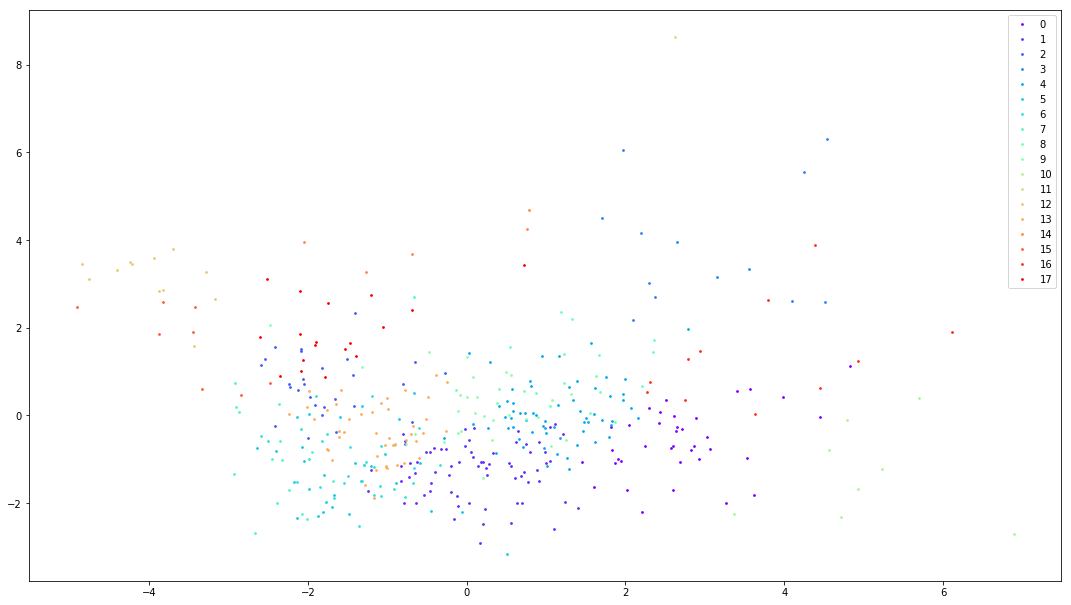

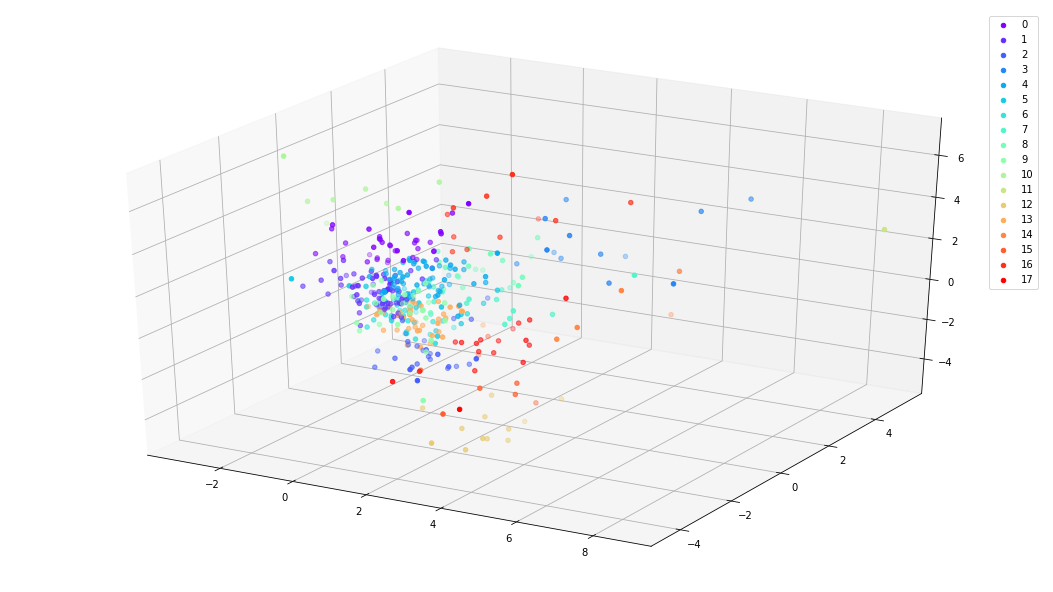

,avg_communities_per_user,avg_distance_from_center,items_posted_last_month,m3_total_retention,pct_female_mau,pct_with_about_me,transaction_avg_weight,transaction_avg_indegree,transaction_avg_outdegree,transaction_indegree_skew,follow_avg_indegree,follow_avg_outdegree,follow_indegree_skew
11,15.761733,8.627000,314.000000,0.000000,1.000000,0.500000,3.745678,145.522388,12.761780,10.402985,22.019608,1.701515,11.941176
7,58.820219,16.047367,130.187500,0.061054,0.692108,0.065712,1.993618,28.448317,2.327828,11.108104,6.934207,1.043476,5.590278
15,14.852460,19.913814,180.000000,0.084576,0.693313,0.027938,1.786058,56.298694,1.939729,27.947911,22.016589,1.017266,20.636127
17,8.088500,32.497419,306.333333,0.084658,0.759494,0.062741,2.068870,56.607746,4.607111,13.527335,20.634439,1.280660,15.545005
13,6.384507,24.215066,256.800000,0.092067,0.764057,0.036187,1.928422,26.539406,3.521317,7.171506,11.892497,1.213491,8.928158
14,11.322819,28.226492,236.800000,0.094027,0.779402,0.051530,4.424682,74.696253,9.393657,8.426565,17.616703,1.337492,12.263576
12,21.361442,22.333909,155.500000,0.094845,0.692257,0.033096,2.079437,34.701268,2.527060,13.047771,41.430154,1.033424,39.087079
5,12.457815,13.315228,344.333333,0.102355,0.609240,0.035044,1.876989,23.985134,3.267334,7.994440,9.108706,1.158546,6.904602
2,6.553811,18.849896,240.666667,0.113465,0.785750,0.039450,1.858678,27.517009,3.333706,8.029880,23.077212,1.155086,19.140809
3,4.769009,18.898734,3962.153846,0.142402,0.812557,0.102012,3.088098,88.558389,32.471216,1.884741,20.622127,2.822546,6.529999


In [263]:
%matplotlib inline
colors = plt.cm.rainbow(np.linspace(0, 1, len(centers)))

#2D viz
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for i,c in enumerate(colors):
    single_clus = viz2D.loc[viz2D['label'] == i]
    plt.scatter(single_clus[0], single_clus[1], s=3, c = c, label=str(i))
plt.legend()
plt.show()

#3D viz
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
for i,c in enumerate(colors):
    single_clus = viz3D.loc[viz3D['label'] == i]
    ax.scatter(single_clus[1], single_clus[2], single_clus[0], s=20, c = c, label=str(i))
plt.legend()
plt.show()

#scatter matrix
#scatter_matrix(data, alpha=0.1, figsize=(6, 6), diagonal='kde')
#plt.show()

corrected_centers = pd.DataFrame(scaler.inverse_transform(centers))
corrected_centers.columns = list(features)
corrected_centers.sort_values(by='m3_total_retention', inplace=True)
corrected_centers

In [ ]:
corrected_centers.to_csv('/Users/joshharris/Google Drive/Community Health/ ')

In [244]:
clust_out[clust_out['label'] == 3]


,cid,name,age,avg_communities_per_user,avg_distance_from_center,m3_total_retention,pct_female_mau,pct_with_about_me,transaction_avg_weight,transaction_avg_indegree,transaction_avg_outdegree,transaction_indegree_skew,follow_avg_indegree,follow_avg_outdegree,follow_indegree_skew,label
cid,,,,,,,,,,,,,,,,
2481,2481,"Summerside, Prince Edward Island Buy and Sell",266.0,51.782609,19.779159,0.062992,0.680000,0.026667,1.618952,42.263158,1.645492,24.684211,16.366667,1.020790,15.033333,3.0
244,244,"New Castle County, DE Buy Sell & Trade",1388.0,8.104987,24.452817,0.086957,0.728261,0.021739,3.408163,75.562738,6.462764,10.692015,20.131488,1.192946,15.875433,3.0
2060,2060,"Biloxi, MS Buy and Sell",352.0,10.391026,40.964931,0.000000,0.714286,0.047619,1.879846,39.685637,3.010691,12.181572,11.247748,1.191317,8.441441,3.0
2090,2090,"Florence, SC Buy and Sell",352.0,14.064815,39.775283,0.000000,0.666667,0.027778,2.381997,34.795580,5.924741,4.872928,22.566667,1.250231,17.050000,3.0
2580,2580,"Fort Smith, Northwest Territories Buy and Sell",223.0,187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,3.0
243,243,The Mama Swap of Maine,1388.0,2.868576,28.679810,0.230769,0.988943,0.088452,2.439362,26.508811,12.284791,1.157856,10.755054,1.976617,4.441141,3.0
2512,2512,"Wandsworth and Battersea, UK Buy and Sell",266.0,128.555556,10.268915,0.068966,0.675676,0.054054,1.666667,4.000000,1.666667,1.400000,6.285714,1.023256,5.142857,3.0
2258,2258,"Drumheller, Alberta Buy and Sell",266.0,18.180556,47.983966,0.111111,0.837209,0.023256,1.384260,40.642857,2.168445,17.742857,6.236842,1.102326,4.657895,3.0
2259,2259,"Eckville, Alberta Buy and Sell",266.0,43.357143,37.283464,0.000000,0.923077,0.076923,1.581215,29.204082,1.711722,16.061224,10.115385,1.023346,8.884615,3.0
